In [59]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def get_ft_headlines(keyword, pages=40):
    headlines = []
    base_url = f"https://www.ft.com/search?q={keyword}&page={{}}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Configure retries
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))

    for page in range(1, pages + 1):
        url = base_url.format(page)
        try:
            response = session.get(url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            for item in soup.find_all('div', class_='o-teaser__content'):
                headline_tag = item.find('a', class_='js-teaser-heading-link')
                date_tag = item.find('time', class_='o-teaser__timestamp-date')

                if headline_tag and date_tag:
                    headline = headline_tag.get_text().strip()
                    date = date_tag.get_text().strip()
                    headlines.append((headline, date))
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            continue

        time.sleep(2)

    return headlines

# Fetch and process headlines for Amazon, Apple, and Nvidia
keywords = ['Amazon', 'Apple', 'Nvidia']
all_headlines = {}

for keyword in keywords:
    print(f"Fetching headlines for {keyword}...")
    headlines = get_ft_headlines(keyword)
    headlines_df = pd.DataFrame(headlines, columns=['Headline', 'Date'])
    headlines_df['Date'] = pd.to_datetime(headlines_df['Date'])
    headlines_df = headlines_df.sort_values(by='Date')
    all_headlines[keyword] = headlines_df

Fetching headlines for Amazon...
Fetching headlines for Apple...
Fetching headlines for Nvidia...


In [60]:
pip install pandas yfinance vaderSentiment

In [61]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

In [62]:
import yfinance as yf
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def process_stock_data(stock_ticker, headlines_df):
    start_date = headlines_df['Date'].min()
    end_date = headlines_df['Date'].max()
    stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    merged_df = pd.merge(headlines_df, stock_data, on='Date', how='left')
    merged_df['Price Movement'] = merged_df['Close'].diff().shift(-1)
    merged_df['Price Movement'] = merged_df['Price Movement'].apply(lambda x: 1 if x > 0 else 0)
    merged_df = merged_df.dropna(subset=['Price Movement'])
    return merged_df

tickers = {'Amazon': 'AMZN', 'Apple': 'AAPL', 'Nvidia': 'NVDA'}
all_data = []

def analyze_sentiment(headline):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(headline)
    return vs['compound']

# # Assume all_headlines is a dictionary with each key being a stock name and each value being a DataFrame containing headlines and their corresponding dates
# all_headlines = {
#     'Amazon': pd.DataFrame({
#         'Date': ['2023-01-01', '2023-01-02'],
#         'Headline': ['Amazon reports record profits', 'Amazon stock falls']
#     }),
#     'Apple': pd.DataFrame({
#         'Date': ['2023-01-01', '2023-01-02'],
#         'Headline': ['Apple launches new iPhone', 'Apple stock rises']
#     }),
#     'Nvidia': pd.DataFrame({
#         'Date': ['2023-01-01', '2023-01-02'],
#         'Headline': ['Nvidia releases new GPU', 'Nvidia stock hits all-time high']
#     })
# }

for keyword, ticker in tickers.items():
    print(f"Processing stock data for {keyword}...")
    merged_df = process_stock_data(ticker, all_headlines[keyword])
    merged_df['Sentiment'] = merged_df['Headline'].apply(analyze_sentiment)
    merged_df['Stock'] = ticker  # Add column for stock ticker
    all_data.append(merged_df)

# Combine all data into a single DataFrame
all_data_df = pd.concat(all_data, ignore_index=True)

print("Stock data processing completed.")
print(all_data_df)


[*********************100%%**********************]  1 of 1 completed

Processing stock data for Amazon...



[*********************100%%**********************]  1 of 1 completed

Processing stock data for Apple...



[*********************100%%**********************]  1 of 1 completed

Processing stock data for Nvidia...


Stock data processing completed.
                                               Headline       Date  \
0     Amazon shares plummet after dismal sales forecast 2022-10-27   
1     Amazon shares plummet after dismal sales forecast 2022-10-27   
2                    Amazon: big spender must cut costs 2022-10-28   
3     US stock futures drop after Amazon earnings di... 2022-10-28   
4     Amazon scrutinises lossmaking units in search ... 2022-11-10   
...                                                 ...        ...   
2971                 Transcript: Nvidia claims top spot 2024-06-19   
2972           Chinese spy threat spooks US tech sector 2024-06-19   
2973                             Nvidia claims top spot 2024-06-19   
2974                  Can TSMC bring a new shape to AI? 2024-06-20   
2975                              It’s an AI market now 2024-06-20   

            Open        High         Low       Close   Adj Close       Volume  \
0     113.919998  114.120003  109.769997  110

In [63]:
# Combine all data into a single DataFrame
combined_df = pd.concat(all_data)

print("Combined data creation completed.")

Combined data creation completed.


In [64]:
combined_df

,Headline,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement,Sentiment,Stock
0,Amazon shares plummet after dismal sales forecast,2022-10-27,113.919998,114.120003,109.769997,110.959999,110.959999,129605400.0,0,-0.2732,AMZN
1,Amazon shares plummet after dismal sales forecast,2022-10-27,113.919998,114.120003,109.769997,110.959999,110.959999,129605400.0,0,-0.2732,AMZN
2,Amazon: big spender must cut costs,2022-10-28,97.910004,103.959999,97.660004,103.410004,103.410004,223133400.0,0,-0.1027,AMZN
3,US stock futures drop after Amazon earnings di...,2022-10-28,97.910004,103.959999,97.660004,103.410004,103.410004,223133400.0,0,-0.4767,AMZN
4,Amazon scrutinises lossmaking units in search ...,2022-11-10,92.940002,98.690002,91.650002,96.629997,96.629997,173414900.0,1,0.1779,AMZN
...,...,...,...,...,...,...,...,...,...,...,...
983,Transcript: Nvidia claims top spot,2024-06-19,NaN,NaN,NaN,NaN,NaN,NaN,0,0.2023,NVDA
984,Chinese spy threat spooks US tech sector,2024-06-19,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.5267,NVDA
985,Nvidia claims top spot,2024-06-19,NaN,NaN,NaN,NaN,NaN,NaN,0,0.2023,NVDA
986,Can TSMC bring a new shape to AI?,2024-06-20,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0000,NVDA


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Model: Logistic Regression
Accuracy: 0.6564
Precision: 0.6615
Recall: 0.5108
F1-score: 0.4232
ROC AUC: 0.7011




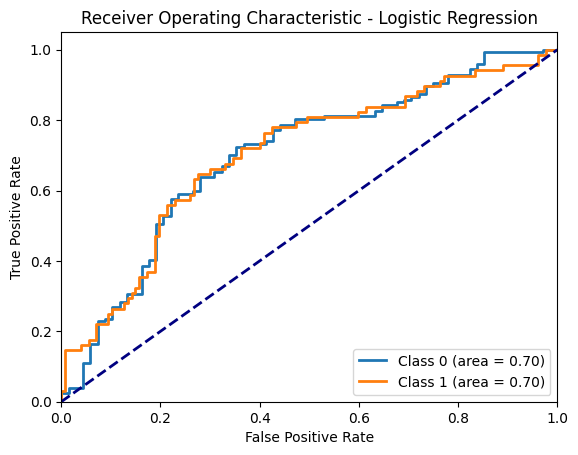

Model: Support Vector Machine
Accuracy: 0.6564
Precision: 0.8273
Recall: 0.5074
F1-score: 0.4101
ROC AUC: 0.6385




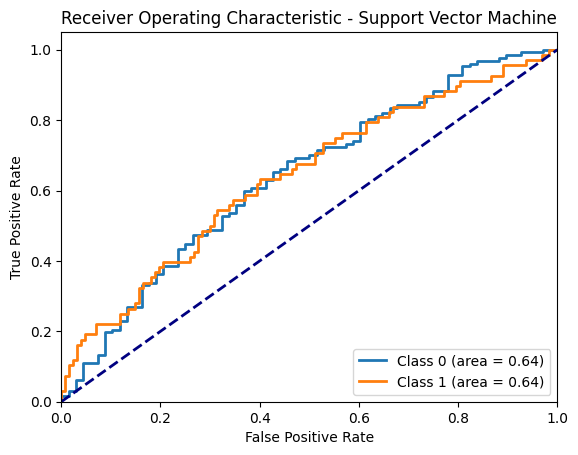

Model: Random Forest
Accuracy: 0.6667
Precision: 0.6667
Recall: 0.5323
F1-score: 0.4741
ROC AUC: 0.6657




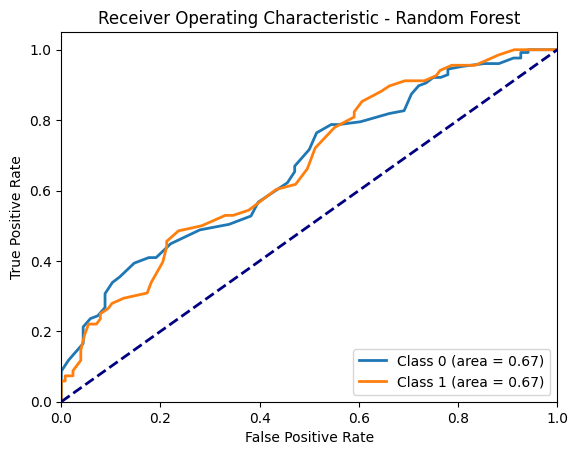

Model: Neural Network
Accuracy: 0.6615
Precision: 0.6186
Recall: 0.6069
F1-score: 0.6098
ROC AUC: 0.6963




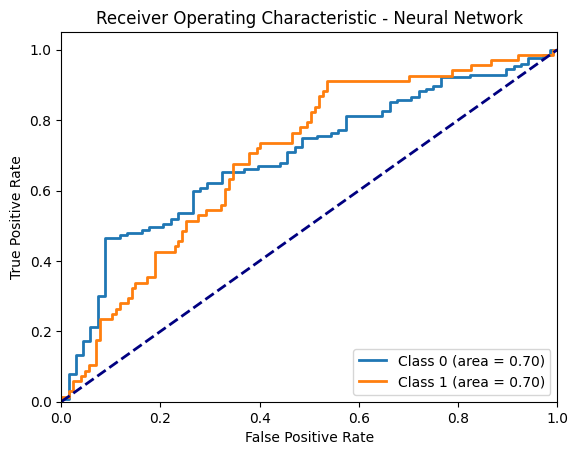

In [65]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def get_ft_headlines(keyword, pages=40):
    headlines = []
    base_url = f"https://www.ft.com/search?q={keyword}&page={{}}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Configure retries
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))

    for page in range(1, pages + 1):
        url = base_url.format(page)
        try:
            response = session.get(url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            for item in soup.find_all('div', class_='o-teaser__content'):
                headline_tag = item.find('a', class_='js-teaser-heading-link')
                date_tag = item.find('time', class_='o-teaser__timestamp-date')

                if headline_tag and date_tag:
                    headline = headline_tag.get_text().strip()
                    date = date_tag.get_text().strip()
                    headlines.append((headline, date))
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            continue

        time.sleep(2)

    return headlines

def process_stock_data(stock_ticker, headlines_df):
    start_date = headlines_df['Date'].min()
    end_date = headlines_df['Date'].max()
    stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    merged_df = pd.merge(headlines_df, stock_data, on='Date', how='left')
    merged_df['Price Movement'] = merged_df['Close'].diff().shift(-1)
    merged_df['Price Movement'] = merged_df['Price Movement'].apply(lambda x: 1 if x > 0 else 0)
    merged_df = merged_df.dropna(subset=['Price Movement'])
    return merged_df

def analyze_sentiment(headline):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(headline)
    return vs['compound']

def prepare_data_for_ml(merged_df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_text = tfidf_vectorizer.fit_transform(merged_df['Headline'])
    X = pd.DataFrame(X_text.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    X['Sentiment'] = merged_df['Sentiment'].values
    y = merged_df['Price Movement']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def evaluate_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Support Vector Machine': SVC(probability=True),
        'Random Forest': RandomForestClassifier(),
        'Neural Network': MLPClassifier(max_iter=500)
    }

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        if y_proba.ndim == 1:
            y_proba = y_proba.reshape(-1, 1)

        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_binarized = lb.transform(y_test)

        if y_test_binarized.shape[1] == 1:
            y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

        roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovo', average='macro')

        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("\n")

        fpr = {}
        tpr = {}
        roc_auc_dict = {}
        for i in range(y_test_binarized.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(y_test_binarized.shape[1]):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc_dict[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {name}')
        plt.legend(loc="lower right")
        plt.show()

keywords = ['Amazon', 'Apple', 'Nvidia']
tickers = ['AMZN', 'AAPL', 'NVDA']
all_data = []

for keyword, ticker in zip(keywords, tickers):
    headlines = get_ft_headlines(keyword)
    headlines_df = pd.DataFrame(headlines, columns=['Headline', 'Date'])
    headlines_df['Date'] = pd.to_datetime(headlines_df['Date'])
    headlines_df = headlines_df.sort_values(by='Date')
    grouped_df = headlines_df.groupby('Date').agg({'Headline': ' | '.join}).reset_index()
    merged_df = process_stock_data(ticker, grouped_df)
    merged_df['Sentiment'] = merged_df['Headline'].apply(analyze_sentiment)
    merged_df['Stock'] = ticker  # Add column for stock ticker
    all_data.append(merged_df)

combined_df = pd.concat(all_data)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text = tfidf_vectorizer.fit_transform(combined_df['Headline'])
X = pd.DataFrame(X_text.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X['Sentiment'] = combined_df['Sentiment'].values
X['Stock'] = combined_df['Stock'].factorize()[0]
y = combined_df['Price Movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
evaluate_classifiers(X_train, X_test, y_train, y_test)